In [ ]:
from torchvision import models

model = models.resnet50(pretrained=True)

In [2]:
import torch

In [3]:
num_classes = 10

model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [11]:
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [12]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [13]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dir = r"C:\Users\іванна\Downloads\Animals-10\train"
val_dir = r"C:\Users\іванна\Downloads\Animals-10\validation"
test_dir = r"C:\Users\іванна\Downloads\Animals-10\test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [15]:
from sklearn.metrics import f1_score

num_epochs = 1
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_labels = []
    all_preds = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        batch_accuracy = (predicted == labels).sum().item() / labels.size(0)
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)} — Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.4f}")

    train_accuracy = correct_train / total_train
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")

Epoch 1/1, Batch 1/144 — Loss: 2.3967, Accuracy: 0.0703
Epoch 1/1, Batch 2/144 — Loss: 1.0154, Accuracy: 0.7656
Epoch 1/1, Batch 3/144 — Loss: 0.5767, Accuracy: 0.8203
Epoch 1/1, Batch 4/144 — Loss: 0.3925, Accuracy: 0.9062
Epoch 1/1, Batch 5/144 — Loss: 0.2204, Accuracy: 0.9297
Epoch 1/1, Batch 6/144 — Loss: 0.2669, Accuracy: 0.9297
Epoch 1/1, Batch 7/144 — Loss: 0.3924, Accuracy: 0.8906
Epoch 1/1, Batch 8/144 — Loss: 0.2584, Accuracy: 0.8906
Epoch 1/1, Batch 9/144 — Loss: 0.1955, Accuracy: 0.9375
Epoch 1/1, Batch 10/144 — Loss: 0.3587, Accuracy: 0.8750
Epoch 1/1, Batch 11/144 — Loss: 0.3196, Accuracy: 0.9297
Epoch 1/1, Batch 12/144 — Loss: 0.2624, Accuracy: 0.9219
Epoch 1/1, Batch 13/144 — Loss: 0.2666, Accuracy: 0.9375
Epoch 1/1, Batch 14/144 — Loss: 0.2192, Accuracy: 0.9453
Epoch 1/1, Batch 15/144 — Loss: 0.2342, Accuracy: 0.9219
Epoch 1/1, Batch 16/144 — Loss: 0.3382, Accuracy: 0.8906
Epoch 1/1, Batch 17/144 — Loss: 0.3020, Accuracy: 0.9062
Epoch 1/1, Batch 18/144 — Loss: 0.2433, 

In [27]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        if batch_idx >= 30:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = test_dataset.classes

report = classification_report(all_labels, all_preds, target_names=class_names, digits=2)
print("Кількість правильно помічених даних:\n")
print(report)


Кількість правильно помічених даних:

              precision    recall  f1-score   support

        cane       0.99      0.92      0.95       730
     cavallo       0.95      0.97      0.96       394
    elefante       0.95      0.97      0.96       217
    farfalla       0.98      0.92      0.95       317
     gallina       0.98      0.95      0.97       465
       gatto       0.86      1.00      0.92       251
       mucca       0.95      0.92      0.93       280
      pecora       0.92      0.96      0.94       273
       ragno       0.96      0.99      0.98       724
  scoiattolo       0.93      0.96      0.95       189

    accuracy                           0.96      3840
   macro avg       0.95      0.96      0.95      3840
weighted avg       0.96      0.96      0.96      3840



In [20]:
torch.save(model.state_dict(), 'model_resnet50_best.pth')

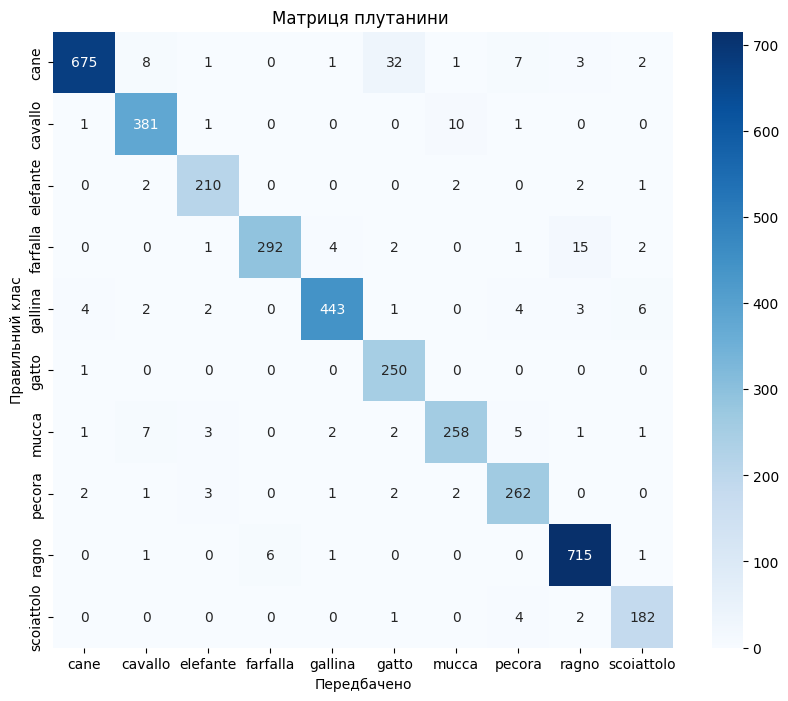

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
label_indices = list(range(len(class_names)))
# Матриця плутанини
cm = confusion_matrix(all_labels, all_preds, labels=label_indices)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Передбачено")
plt.ylabel("Правильний клас")
plt.title("Матриця плутанини ")
plt.show()


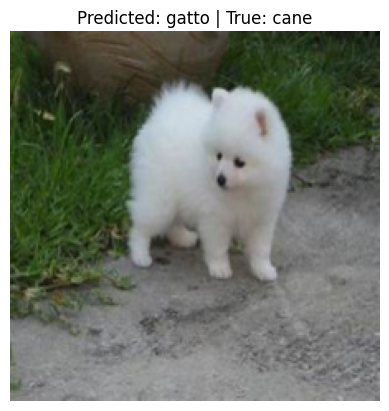

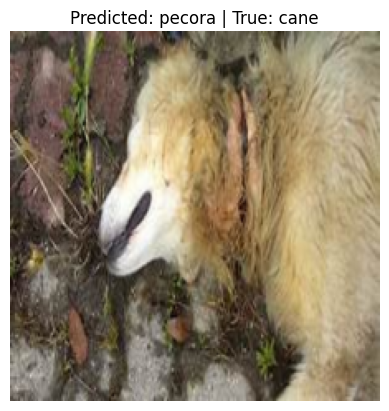

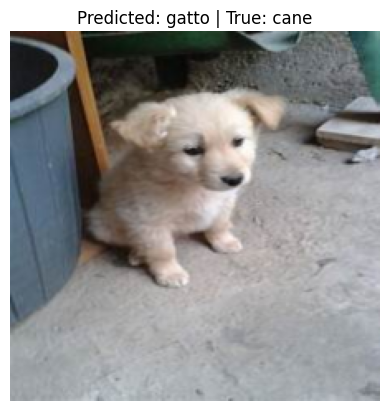

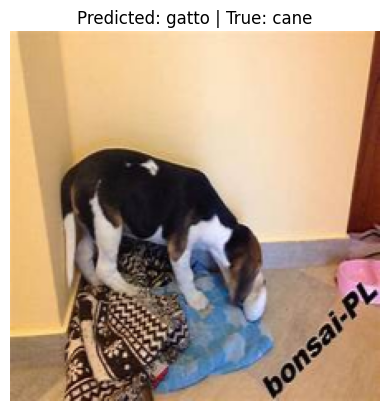

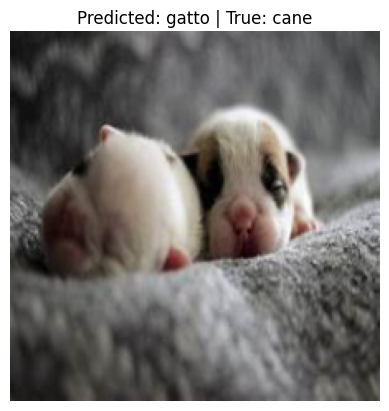

In [23]:
import numpy as np
import matplotlib.pyplot as plt
wrong_imgs = []
wrong_preds = []
wrong_labels = []

model.eval()
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        if batch_idx >= 2:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(preds)):
            if preds[i] != labels[i]:
                wrong_imgs.append(inputs[i].cpu())
                wrong_preds.append(preds[i].cpu().item())
                wrong_labels.append(labels[i].cpu().item())

# Показуємо перші 5 помилок
n = min(5, len(wrong_imgs))
for i in range(n):
    img = (wrong_imgs[i])
    img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.title(f"Predicted: {class_names[wrong_preds[i]]} | True: {class_names[wrong_labels[i]]}")
    plt.axis('off')
    plt.show()
